In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score

# Classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# XGBoost
import xgboost as xgb

In [2]:
df = pd.read_csv("ai4i2020.csv")
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


## # Basic info

In [3]:
display(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
UDI,10000.0,NaN,NaN,NaN,5000.5,2886.89568,1.0,2500.75,5000.5,7500.25,10000.0
Product ID,10000,10000,L57163,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,10000,3,L,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Air temperature [K],10000.0,NaN,NaN,NaN,300.00493,2.000259,295.3,298.3,300.1,301.5,304.5
Process temperature [K],10000.0,NaN,NaN,NaN,310.00556,1.483734,305.7,308.8,310.1,311.1,313.8
Rotational speed [rpm],10000.0,NaN,NaN,NaN,1538.7761,179.284096,1168.0,1423.0,1503.0,1612.0,2886.0
Torque [Nm],10000.0,NaN,NaN,NaN,39.98691,9.968934,3.8,33.2,40.1,46.8,76.6
Tool wear [min],10000.0,NaN,NaN,NaN,107.951,63.654147,0.0,53.0,108.0,162.0,253.0
Machine failure,10000.0,NaN,NaN,NaN,0.0339,0.180981,0.0,0.0,0.0,0.0,1.0
TWF,10000.0,NaN,NaN,NaN,0.0046,0.067671,0.0,0.0,0.0,0.0,1.0


## # Null check

In [4]:
print("Nulls per column:\n", df.isna().sum())

Nulls per column:
 UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64


In [16]:
df['Machine failure'].value_counts()

Machine failure
0    9661
1     339
Name: count, dtype: int64

In [17]:
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Combine one-hot columns into single label
def get_failure_type(row):
    for failure in failure_types:
        if row[failure] == 1:
            return failure
    return "No Failure"

df['failure_type'] = df.apply(get_failure_type, axis=1)
df['failure_type'].value_counts()

failure_type
No Failure    9652
HDF            115
PWF             91
OSF             78
TWF             46
RNF             18
Name: count, dtype: int64

In [18]:
le = LabelEncoder()
df['Type_encoded'] = le.fit_transform(df['Type'])

# Define feature columns
feature_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
                'Torque [Nm]', 'Tool wear [min]', 'Type_encoded']

# Feature matrix for Model 1
X = df[feature_cols]
y_binary = df['Machine failure']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, stratify=y_binary, random_state=42)

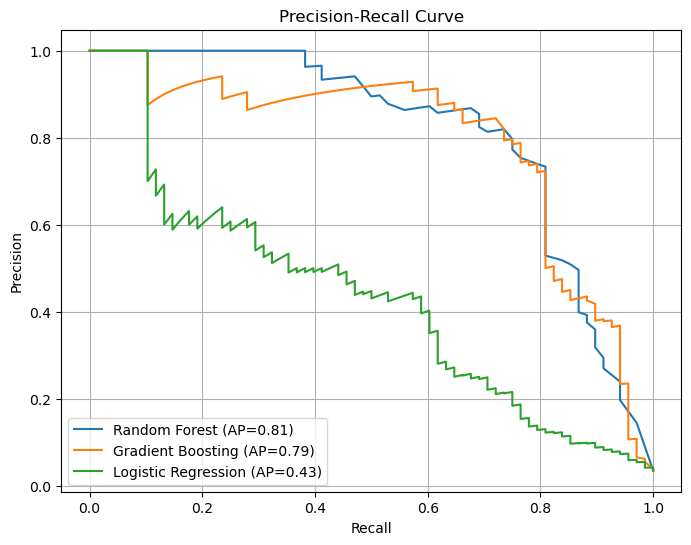

In [21]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression()
}

# Precision-Recall Curve
plt.figure(figsize=(8,6))
for name, model in models.items():
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, probs)
    ap = average_precision_score(y_test, probs)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

In [22]:
failed_df = df[df['Machine failure'] == 1].copy()

# Target for Model 2
X_multi = failed_df[feature_cols]
y_multi = failed_df['failure_type']

# Encode labels
from sklearn.preprocessing import LabelEncoder
le_multi = LabelEncoder()
y_multi_encoded = le_multi.fit_transform(y_multi)

# Scale
X_multi_scaled = scaler.fit_transform(X_multi)

# Train-test split
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_multi_scaled, y_multi_encoded, test_size=0.2, stratify=y_multi_encoded, random_state=42)


Decision Tree Classification Report:

              precision    recall  f1-score   support

         HDF       0.76      0.96      0.85        23
  No Failure       1.00      0.50      0.67         2
         OSF       0.77      0.62      0.69        16
         PWF       0.89      0.94      0.92        18
         TWF       0.83      0.56      0.67         9

    accuracy                           0.81        68
   macro avg       0.85      0.72      0.76        68
weighted avg       0.81      0.81      0.80        68



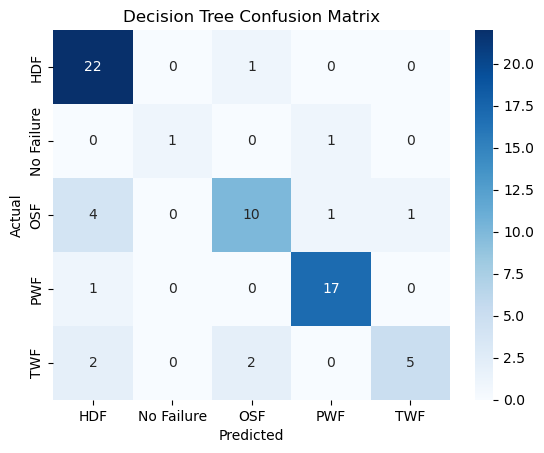


Naive Bayes Classification Report:

              precision    recall  f1-score   support

         HDF       0.69      0.96      0.80        23
  No Failure       0.00      0.00      0.00         2
         OSF       0.80      0.75      0.77        16
         PWF       0.80      0.67      0.73        18
         TWF       0.83      0.56      0.67         9

    accuracy                           0.75        68
   macro avg       0.62      0.59      0.59        68
weighted avg       0.74      0.75      0.73        68



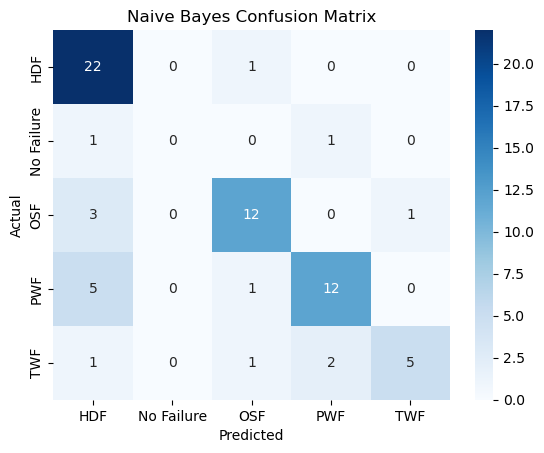


SVM Classification Report:

              precision    recall  f1-score   support

         HDF       0.77      1.00      0.87        23
  No Failure       0.00      0.00      0.00         2
         OSF       0.78      0.88      0.82        16
         PWF       0.79      0.61      0.69        18
         TWF       1.00      0.67      0.80         9

    accuracy                           0.79        68
   macro avg       0.67      0.63      0.64        68
weighted avg       0.78      0.79      0.78        68



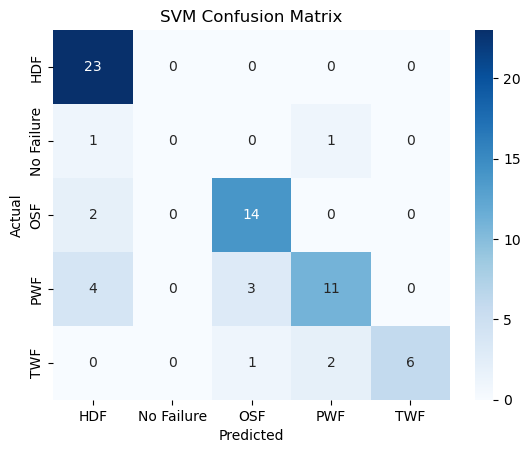


XGBoost Classification Report:

              precision    recall  f1-score   support

         HDF       0.88      1.00      0.94        23
  No Failure       1.00      1.00      1.00         2
         OSF       0.85      0.69      0.76        16
         PWF       0.95      1.00      0.97        18
         TWF       0.88      0.78      0.82         9

    accuracy                           0.90        68
   macro avg       0.91      0.89      0.90        68
weighted avg       0.89      0.90      0.89        68



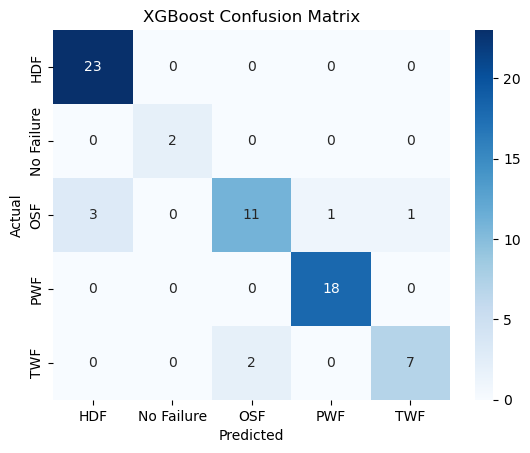

In [23]:
multi_models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True),
    "XGBoost": xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)
}

for name, model in multi_models.items():
    model.fit(X_train_m, y_train_m)
    y_pred = model.predict(X_test_m)
    print(f"\n{name} Classification Report:\n")
    print(classification_report(y_test_m, y_pred, target_names=le_multi.classes_))
    
    cm = confusion_matrix(y_test_m, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le_multi.classes_, yticklabels=le_multi.classes_, cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()